In [1]:
import sys
sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/RelWithDebInfo')
sys.path.insert(0, '/home/sci/duong/Desktop/idx2/build/Source/Python')
#sys.path.insert(0, 'F:/Workspace/idx2/build/Source/Python/Debug')
import idx2Py as i2p
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import *
import concurrent.futures

In [2]:
%%time
input_dir  = 'J:/nasa'
input_dir = '/usr/sci/cedmav/hello'
dataset = 'llc4320'
times_per_file = 64
times_per_brick = 64
vmin = -10
vmax = 10
#vmin = -5.35
#vmax = 3.24

CPU times: total: 0 ns
Wall time: 0 ns


## Set up color map

In [3]:
import colorsys

Points = [
  -10,
  -2.18552,
  -0.260014,
  0.00702716,
  0.372452,
  0.709768,
  10  
]

RGBPoints = [  
  [0.27843137254900002, 0.27843137254900002, 0.85882352941200002],
  [0.0, 0.33333333333333331, 1.0],
  [0.33333333333333331, 0.66666666666666663, 1.0],
  [0.0, 0.0, 0.49803921568627452],  
  [0.82745098039215681, 1.0, 0.73333333333333328],
  [1.0, 0.66666666666666663, 0.0],
  [0.87843137254899994, 0.30196078431399997, 0.30196078431399997]
]

def get_continuous_cmap(rgb_list, float_list=None):
  if float_list:
    # normalize the float list
    min_val = min(float_list)
    max_val = max(float_list)
    my_range = max_val - min_val
    float_list = [(v - min_val)/my_range for v in float_list]
    print(float_list)
  else:
    float_list = list(np.linspace(0, 1, len(rgb_list)))

  cdict = dict()  
  for num, col in enumerate(['red', 'green', 'blue']):
    col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(0, len(float_list))]
    cdict[col] = col_list
  cmp = matplotlib.colors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
  return cmp

my_cmap = get_continuous_cmap(RGBPoints, Points)

[0.0, 0.39072399999999996, 0.4869993, 0.500351358, 0.5186225999999999, 0.5354884, 1.0]


In [4]:
def get_file_name(dataset, field, face, depth, time_from, time_to):
  return input_dir + '/' + dataset + '/' + field + '-face-' + repr(face) + '-depth-' + repr(depth) + '-time-' + repr(time_from) + '-' + repr(time_to) + '.idx2' 

def get_extent(face):
  if (face < 2):
    return (0, 0, 4320, 12960)
  elif (face > 2):
    return (0, 0, 12960, 4320)
  return (0, 0, 4320, 4320)

In [5]:
# Query 
# extent should be a 4-tuple: (from_x, from_y, dim_x, dim_y)
def query_data(dataset, field, face, depth, time, downsampling, accuracy, extent=None):
  # determine the time step range to query from
  file_time_from    = (time // times_per_file) * times_per_file
  file_time_to      = file_time_from + times_per_file
  time_in_file      = time % times_per_file
  time_extent_from  = (time_in_file // times_per_brick) * times_per_brick
  
  # split the extent into 4 pieces
  if extent == None:
    extent = get_extent(face)
  e0 = extent
  e1 = (e0[0]           , e0[1]           , e0[2]//2   , e0[3]//2   )
  e2 = (e0[0]+(e0[2]//2), e0[1]           , e0[2]-e1[2], e0[3]//2   )
  e3 = (e0[0]           , e0[1]+(e0[3]//2), e0[2]//2   , e0[3]-e1[3])
  e4 = (e0[0]+(e0[2]//2), e0[1]+(e0[3]//2), e0[2]-e1[2], e0[3]-e1[3])
  e1 = (e1[0], e1[1], time_extent_from, e1[2], e1[3], times_per_brick)
  e2 = (e2[0], e2[1], time_extent_from, e2[2], e2[3], times_per_brick)
  e3 = (e3[0], e3[1], time_extent_from, e3[2], e3[3], times_per_brick)
  e4 = (e4[0], e4[1], time_extent_from, e4[2], e4[3], times_per_brick)

  file = get_file_name(dataset, field, face, depth, file_time_from, file_time_to)
  print(file)
    
  array = None
  with concurrent.futures.ThreadPoolExecutor() as executor:
    f1 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e1, downsampling, accuracy)    
    f2 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e2, downsampling, accuracy)
    f3 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e3, downsampling, accuracy)
    f4 = executor.submit(i2p.DecodeExtent3f32, file, input_dir, e4, downsampling, accuracy)
    a1 = f1.result()
    a2 = f2.result()
    a3 = f3.result()
    a4 = f4.result()
    shape = (a1.shape[0], a1.shape[1] + a4.shape[1], a1.shape[2] + a4.shape[2])
    print(a1.shape, a2.shape, a3.shape, a4.shape)
    print(shape)
    array = np.empty(shape)
    
    array[:, :a1.shape[1], :a1.shape[2]] = a1
    array[:, :a2.shape[1], a2.shape[2]:] = a2
    array[:, a3.shape[1]:, :a3.shape[2]] = a3
    array[:, a4.shape[1]:, a4.shape[2]:] = a4
  
  return array

In [10]:
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

C:\Users\Duong\AppData\Local\Temp\ipykernel_33552\2294010394.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# Visualize a single face through time

J:/nasa/llc4320/u-face-0-depth-0-time-0-64.idx2
(64, 406, 136) (64, 406, 136) (64, 406, 136) (64, 406, 136)
(64, 812, 272)


<IPython.core.display.Javascript object>


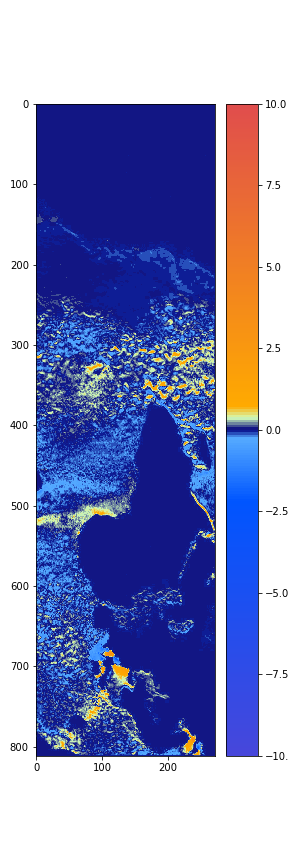

interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='500px'), max=63), Output()), _d…

CPU times: total: 54.6 s
Wall time: 14.8 s


<function __main__.f(t)>

In [14]:
%%time

accuracy = 1
downsampling = [4, 4, 1]
time_block = 0

array = query_data(dataset, 'u', 0, 0, 0, downsampling, accuracy)

fig = plt.figure(figsize = (4, 12))
plot = plt.imshow(array[0, :, :], origin = 'upper', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
plt.colorbar(plot)
first_draw = True
def f(t): # get time step t
  global time_block
  global array
  global first_draw
  
  curr_time_block = t // times_per_brick
  if curr_time_block != time_block:        
    array = query_data(dataset, 'u', 0, 0, t, downsampling, accuracy)
    time_block = curr_time_block
  tt = min((t - time_block * times_per_brick) // pow(2, downsampling[2]), array.shape[0]-1)
  plot.set_data(array[tt,:,:])
  if first_draw:
    first_draw = False
    fig.canvas.draw_idle()
  
  plt.show()
  return

interact(f, t = widgets.IntSlider(min=0, max=63, step=1, value=0, layout=Layout(width='500px')));

# Visualize four faces through time

In [8]:
%%time
%matplotlib inline

accuracy = 1
downsampling = [3, 3, 1]

a0 = None
a1 = None
a3 = None
a4 = None

with concurrent.futures.ThreadPoolExecutor() as executor:
    f0 = executor.submit(query_data, dataset, 'u', 0, 0, 0, downsampling, accuracy)    
    f1 = executor.submit(query_data, dataset, 'u', 1, 0, 0, downsampling, accuracy)
    f3 = executor.submit(query_data, dataset, 'v', 3, 0, 0, downsampling, accuracy)
    f4 = executor.submit(query_data, dataset, 'v', 4, 0, 0, downsampling, accuracy)
    a0 = f0.result()
    a1 = f1.result()
    a3 = f3.result()
    a4 = f4.result()


# vmin = min(np.min(array0), np.min(array1), np.min(array3), np.min(array4))
# vmax = max(np.max(array0), np.max(array1), np.max(array3), np.max(array4))

def f(t): # get time step t
  fig, ((ax0, ax1, ax3, ax4)) = plt.subplots(1, 4, figsize=([15, 12]))
  ax0.axis('off')
  ax1.axis('off')
  ax3.axis('off')
  ax4.axis('off')

  ax0.imshow(a0[t, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  ax1.imshow(a1[t, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  ax3.imshow(np.rot90(a3[t, :, :]), origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  ax4.imshow(np.rot90(a4[t, :, :]), origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax) 
  return  

interact(f, t = widgets.IntSlider(min = 0, max = a1.shape[0] - 1, step = 1, value = 0, layout = Layout(width = '500px')));

J:/nasa/llc4320/u-face-0-depth-0-time-0-64.idx2
J:/nasa/llc4320/u-face-1-depth-0-time-0-64.idx2
J:/nasa/llc4320/v-face-3-depth-0-time-0-64.idx2
J:/nasa/llc4320/v-face-4-depth-0-time-0-64.idx2
(33, 811, 271) (33, 811, 271) (33, 811, 271) (33, 811, 271)
(33, 1622, 542)
(33, 811, 271) (33, 811, 271) (33, 811, 271) (33, 811, 271)
(33, 1622, 542)
(33, 271, 811) (33, 271, 811) (33, 271, 811) (33, 271, 811)
(33, 542, 1622)
(33, 271, 811) (33, 271, 811) (33, 271, 811) (33, 271, 811)
(33, 542, 1622)


interactive(children=(IntSlider(value=0, description='t', layout=Layout(width='500px'), max=32), Output()), _d…

CPU times: total: 59.1 s
Wall time: 6.66 s


<function __main__.f(t)>

# Visualize four faces through depths

In [9]:
%%time
%matplotlib inline

array0 = None
array1 = None
array3 = None
array4 = None

downsampling = [3, 3, 3]

def f(d): # get time step t
  with concurrent.futures.ThreadPoolExecutor() as executor:
    accuracy = 0.01
    future0 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-0-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)    
    future1 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-1-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)
    future3 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-3-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)
    future4 = executor.submit(i2p.Decode3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-4-depth-' + repr(d) + '-time-0-32.idx2', input_dir, downsampling, accuracy)
    array0 = future0.result()
    array1 = future1.result()
    array3 = future3.result()
    array4 = future4.result()
    fig, ((ax0, ax1, ax3, ax4)) = plt.subplots(1, 4, figsize=([15, 12]))
    ax0.axis('off')
    ax1.axis('off')
    ax3.axis('off')
    ax4.axis('off')
    ax0.imshow(array0[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
    ax1.imshow(array1[0, :, :], origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
    ax3.imshow(np.rot90(array3[0, :, :]), origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
    ax4.imshow(np.rot90(array4[0, :, :]), origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax) 
  return  

interact(f, d = widgets.IntSlider(min = 0, max = 89, step = 1, value = 0, layout = Layout(width = '800px')));

interactive(children=(IntSlider(value=0, description='d', layout=Layout(width='800px'), max=89), Output()), _d…

CPU times: total: 3.09 s
Wall time: 1.08 s


<function __main__.f(d)>

# Vertical slicing along y (constant x) at a particular time step

In [13]:
%%time
%matplotlib inline

downsampling = [2, 2, 2]

timestep = 0
ndepths = 90
n = 2160

def to_face(f):
  if (f >= 2):
    return f + 1;
  return f
    
def f(x):
  face = to_face(x // n)
  xx = x % n # local x coordinate within the face
  nx = 0
  ny = ndepths
  future_array = [None] * ndepths
  with concurrent.futures.ThreadPoolExecutor() as executor:
    for d in range(0, ndepths):  
      extent = (xx, 0, timestep, 1, n * 3, 1)    
      if (face > 2):
        extent = (0, xx, timestep, n * 3, 1, 1)
      #print(extent)
      #print('D:/Datasets/nasa/llc_2160_32/llc2160/u-face-' + repr(face) + '-depth-' + repr(d) + '-time-0-32.idx2')
      future_array[d] = executor.submit(i2p.DecodeExtent3f32, 'D:/Datasets/nasa/llc_2160_32/llc2160/u-face-' + repr(face) + '-depth-' + repr(d) + '-time-0-32.idx2', input_dir, extent, downsampling, accuracy)

  array = None # store the whole result
  for d in range(0, ndepths):
    # figure out the shape of the output array once (at depth 0)
    a = future_array[d].result()
    #if (face > 2):
      #a = np.rot90(a)
    if d == 0:
      print(a.shape)
      if (face < 2):
        nx = a.shape[1]
      else:
        nx = a.shape[2]
      array = np.empty((ny, nx))
      
    if (face < 2):
      array[d, :] = a[0, :, 0]
    else:
      array[d, :] = a[0, 0, :]
    #array[d, :] = a[0, :, (xx * a.shape[2]) // n]

  fig = plt.plot(figsize = ([1024, 90]))
  plt.imshow(array, origin = 'lower', cmap = my_cmap, aspect = 'auto', vmin = vmin, vmax = vmax)
  plt.show()
  return

interact(f, x = widgets.IntSlider(min = 0, max = 8639, step = 10, value = 0, layout = Layout(width = '800px')));

interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='800px'), max=8639, step=10), Ou…

CPU times: total: 37.1 s
Wall time: 3.65 s


<function __main__.f(x)>